Matplotlib is building the font cache; this may take a moment.
/tmp/xpython_42/546951995.py:35: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  import random,pylab,itertools,sys,optparse,scipy.stats


-----------screen output--------------
combine 1 and 2 at 0.14428212091991038 unit time, 14.428212091991039 generations
combine 4 and 0 at 0.14658838128297344 unit time, 14.658838128297344 generations
mutate 3 at 0.15248995406668756 unit time, 15.248995406668756 generations
combine 3 and [1, 2] at 0.3468212543133611 unit time, 34.68212543133611 generations
mutate [4, 0] at 0.965356292129032 unit time, 96.53562921290319 generations
combine [3, [1, 2]] and [4, 0] at 1.523365113357929 unit time, 152.3365113357929 generations
[[[3, [1, 2]], [4, 0]]]
2 mutations


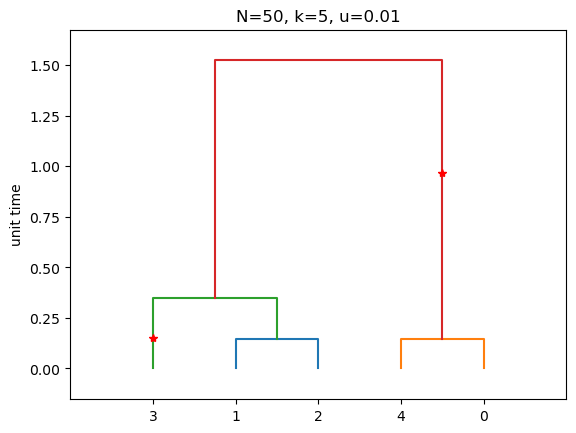

In [1]:
'''
Copyright (C) 2011, 2014 by Xuebing Wu and Robert C. Berwick

This program is free software; you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation; either version 2 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License along
with this program; if not, write to the Free Software Foundation, Inc.,
51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA

python script for coalescence model simulation

author: Xuebing Wu (wuxbl@mit.edu)

date: 10-29-2011

Usage:
    python coalesce_with_mutation.py
    python coalesce_with_mutation.py -N 50 -k 5 -u 0.01 -m 1    

check the help message:
    python coalesce_with_mutation.py -h
 
'''

# OM: changed print -> print() from Python 2 to Python 3

import random,pylab,itertools,sys,optparse,scipy.stats

def choose(n, k):
    # calculate n_choose_k
    p = 1
    for t in range(min(k, n - k)): # OM: changed xrange -> range
        p = (p * (n - t)) // (t + 1)
    return p

def coalesce_with_mutation(N,k,u):

    # compute theta
    theta = 4*N*u
    
    event_type = None

    # variable to store the unit time of each event
    coalesce_event = []
    coalesce_time = []
    mutation_event = []
    mutation_time = []
    current_time = [0]

    # variable to store the genealogy
    lineage = list(range(k)) # OM: added list
    
    print('-----------screen output--------------')
    
    while k > 1: # when there are more than two lineages to coalesce
        
        # draw from exponential distribution
        t = scipy.stats.expon.rvs(scale=2.0/k/(k-1+theta))
        
        # the time the current event happens
        current_time.append(current_time[-1]+t)
            
        # determine the event type: mutation or coalescence
        if pylab.rand() < theta/(k-1+theta):
            event_type = 'mutation'
        else:
            event_type = 'coalescence'
        
        if event_type == 'coalescence':
            coalesce_time.append(current_time[-1])
            # pick two random lineages
            i,j = random.sample(range(k),2)
            print ('combine',lineage[i],'and',lineage[j],'at',current_time[-1],'unit time,',current_time[-1]*2*N,'generations')
            # update lineage structure
            lineage[i] = [lineage[i],lineage[j]]
            coalesce_event.append(lineage[i])
            del lineage[j]
            # update the number of lineages to coalesce
            k = len(lineage)
            
        else:# mutation
            mutation_time.append(current_time[-1])
            # pick one random lineage to be mutated
            i = random.sample(range(k),1)[0]
            mutation_event.append(lineage[i])
            print ('mutate',lineage[i],'at',current_time[-1],'unit time,',current_time[-1]*2*N,'generations')

    # output final lineage structure
    print (lineage)
    # output number of mutations
    print (len(mutation_event),'mutations')

    return lineage,coalesce_time,mutation_time,coalesce_event,mutation_event

def drawtree(fig,coalesce_time,mutation_time,coalesce_event,mutation_event):
    # number of lineages
    k = len(coalesce_time)+1
    # position of nodes
    xpos = {}
    ypos = {}
    tree = str(coalesce_event[-1]).replace('[','').replace(']','')
    node_order = pylab.array([int(n) for n in tree.split(',')])
    #pylab.figure(facecolor='w')
    axes = fig.add_subplot(111)
    for i in range(k):
        xpos[str(node_order[i])] = float(i)
        ypos[str(node_order[i])] = 0.0
        #axes.text(i,0,str(node_order[i]),horizontalalignment='center',verticalalignment='top')
    for i in range(len(coalesce_event)):
        xpos[str(coalesce_event[i])] = (xpos[str(coalesce_event[i][0])] + xpos[str(coalesce_event[i][1])])/2
        ypos[str(coalesce_event[i])] = coalesce_time[i]
        axes.plot([xpos[str(coalesce_event[i][0])],xpos[str(coalesce_event[i][0])],xpos[str(coalesce_event[i][1])],xpos[str(coalesce_event[i][1])]],[ypos[str(coalesce_event[i][0])],ypos[str(coalesce_event[i])],ypos[str(coalesce_event[i])],ypos[str(coalesce_event[i][1])]])
        #pylab.text(xpos[str(coalesce_event[i])],ypos[str(coalesce_event[i])],str(coalesce_event[i]))
    #plot mutation event
    for i in range(len(mutation_event)):
        axes.plot(xpos[str(mutation_event[i])],mutation_time[i],'r*',mec='r')
    axes.set_ylabel('unit time')
    axes.set_xlim(-1,k)
    axes.set_ylim(-coalesce_time[-1]/10,coalesce_time[-1]*1.1)
    axes.set_xticks(range(k))
    axes.set_xticklabels( node_order[range(k)] )
    #pylab.show()
    
def main():
    # Parse command line    
    parser = optparse.OptionParser( usage="%prog [options] " )
    parser.add_option("-N","--population-size", type='int',dest="N",default=50,
                      help="Total number of lineages in the population is 2N (default N=50) " )
    parser.add_option("-k","--num-lineage", dest="k",type='int',default=5,
                      help="Number of lineages to coalesce (default=5)" ) 
    parser.add_option("-u","--mutation-rate",dest="u",type='float',default='0.01',
                      help="Mutation rate (default=0.01)" )       
    parser.add_option("-m","--num-simulation", type='int',dest="m",default=1,
                      help="Number of simulations to run (default=1) ")

    options, args = parser.parse_args()
    
    if  options.m == 1: # simulate once, will plot the genealogy tree
        lineage,coalesce_time,mutation_time,coalesce_event,mutation_event = coalesce_with_mutation(options.N,options.k,options.u)        
        drawtree(pylab.figure(),coalesce_time,mutation_time,coalesce_event,mutation_event)
        pylab.title('N='+str(options.N)+', k='+str(options.k)+', u='+str(options.u))
    else:
        firstCoalesceTime = []
        finalCoalesceTime = []
        numMutation = []
        for i in range(options.m):
            lineage,coalesce_time,mutation_time,coalesce_event,mutation_event = coalesce_with_mutation(options.N,options.k,options.u)
            firstCoalesceTime.append(coalesce_time[0])
            finalCoalesceTime.append(coalesce_time[-1])
            numMutation.append(len(mutation_event))
        print ('-----------statistics---------------')
        print ('first coalescence time: \tmean =',pylab.mean(firstCoalesceTime),'\tvar =',pylab.var(firstCoalesceTime))
        print ('last coalescence time: \tmean =',pylab.mean(finalCoalesceTime),'\tvar =',pylab.var(finalCoalesceTime))
        print ('number of mutations: \tmean =',pylab.mean(numMutation),'\tvar =',pylab.var(numMutation))
        # plot histgram
        pylab.figure()
        pylab.hist(firstCoalesceTime,bins=20)
        pylab.title('first coalescence time')
        pylab.xlabel('unit time')
        pylab.ylabel('number of simulations')
        pylab.figure()
        pylab.hist(finalCoalesceTime,bins=20)
        pylab.title('last coalescence time')
        pylab.xlabel('unit time')
        pylab.ylabel('number of simulations')        
        pylab.figure()
        pylab.hist(numMutation,bins=20)  
        pylab.title('number of mutations')     
        pylab.xlabel('unit time')
        pylab.ylabel('number of simulations')         
    pylab.show()

if __name__ == "__main__":
    main()
